In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

dataset = pd.read_csv("../data/logfile-storage-v5.csv", delimiter=";")
dataset.head()

,datacenter_id,datacenter_name,datacenter_storage_energy,storage_id,system,storage_capacity,capacity_used,active_duration,idle_intervals,duration,total_energy_active,total_energy_idle,average_rotation_latency,average_seek_Time,max_internal_data_transfer_rate,is_active,idle_power,active_power,files,Unnamed: 19
0,3,Datacenter_1,4.099681e+06,0,storage,900000.0,899584.0,4635.372761,1.0000003378537212:,9447.595287,26885.162012,3.000001,0.003,0.004,198.0,False,3.0,5.8,"55596,3072,15.524809784082704:450990,1024,5.18...",NaN
1,3,Datacenter_1,4.099681e+06,1,storage,900000.0,899584.0,4552.153376,1.0000000057506384:,9447.595287,26402.489581,3.000000,0.003,0.004,198.0,False,3.0,5.8,"1002363,1024,5.178738666087011:287333,512,2.59...",NaN
2,3,Datacenter_1,4.099681e+06,2,storage,900000.0,899584.0,4712.463046,1.0000000137015315:,9447.595287,27332.285668,3.000000,0.003,0.004,198.0,False,3.0,5.8,"3-6852,8192,41.38862101694565:24-285602,512,2....",NaN
3,3,Datacenter_1,4.099681e+06,3,storage,900000.0,899584.0,4924.857340,1.0000000205963306:,9447.595287,28564.172570,3.000000,0.003,0.004,198.0,False,3.0,5.8,"303602,3584,18.10363760760568:1-591519,3072,15...",NaN
4,3,Datacenter_1,4.099681e+06,4,storage,900000.0,899584.0,4813.303893,1.000000024323157:,9447.595287,27917.162579,3.000000,0.003,0.004,198.0,False,3.0,5.8,"2-878359,1024,5.1852412125875285:2-1002249,102...",NaN


### Storage placement

#### Current data placement

Disk ID '0' at datacenter 'Datacenter_1' has 208 stored files.
Disk ID '1' at datacenter 'Datacenter_1' has 148 stored files.
Disk ID '2' at datacenter 'Datacenter_1' has 140 stored files.
Disk ID '3' at datacenter 'Datacenter_1' has 172 stored files.
Disk ID '4' at datacenter 'Datacenter_1' has 137 stored files.
Disk ID '5' at datacenter 'Datacenter_1' has 166 stored files.
Disk ID '6' at datacenter 'Datacenter_1' has 215 stored files.
Disk ID '7' at datacenter 'Datacenter_1' has 238 stored files.
Disk ID '8' at datacenter 'Datacenter_1' has 195 stored files.
Disk ID '9' at datacenter 'Datacenter_1' has 183 stored files.
Disk ID '10' at datacenter 'Datacenter_1' has 190 stored files.
Disk ID '11' at datacenter 'Datacenter_1' has 199 stored files.
Disk ID '12' at datacenter 'Datacenter_1' has 160 stored files.
Disk ID '13' at datacenter 'Datacenter_1' has 155 stored files.
Disk ID '14' at datacenter 'Datacenter_1' has 198 stored files.
Disk ID '15' at datacenter 'Datacenter_1' has 140 

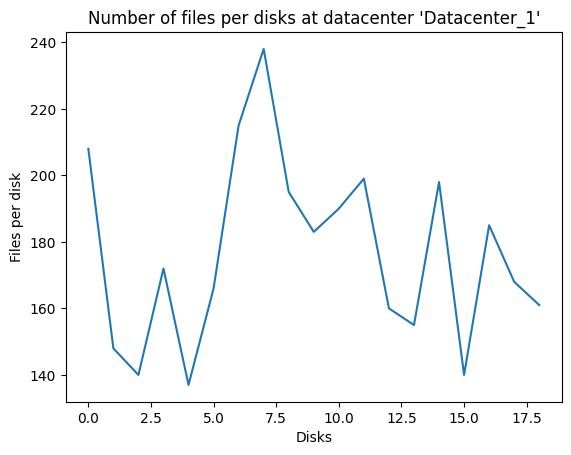

Disk ID '20' at datacenter 'Datacenter_2' has 326 stored files.
Disk ID '21' at datacenter 'Datacenter_2' has 326 stored files.
Disk ID '22' at datacenter 'Datacenter_2' has 326 stored files.
Disk ID '23' at datacenter 'Datacenter_2' has 326 stored files.
Disk ID '24' at datacenter 'Datacenter_2' has 326 stored files.
Disk ID '25' at datacenter 'Datacenter_2' has 326 stored files.
Disk ID '26' at datacenter 'Datacenter_2' has 326 stored files.
Disk ID '27' at datacenter 'Datacenter_2' has 326 stored files.
Disk ID '28' at datacenter 'Datacenter_2' has 326 stored files.
Disk ID '29' at datacenter 'Datacenter_2' has 326 stored files.
Disk ID '30' at datacenter 'Datacenter_2' has 326 stored files.
Disk ID '31' at datacenter 'Datacenter_2' has 326 stored files.
Disk ID '32' at datacenter 'Datacenter_2' has 326 stored files.
Disk ID '33' at datacenter 'Datacenter_2' has 326 stored files.


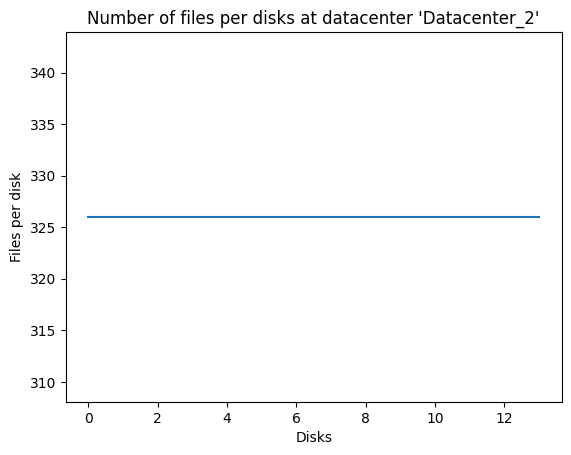

Disk ID '35' at datacenter 'Datacenter_3' has 326 stored files.
Disk ID '36' at datacenter 'Datacenter_3' has 326 stored files.
Disk ID '37' at datacenter 'Datacenter_3' has 326 stored files.
Disk ID '38' at datacenter 'Datacenter_3' has 326 stored files.
Disk ID '39' at datacenter 'Datacenter_3' has 326 stored files.
Disk ID '40' at datacenter 'Datacenter_3' has 326 stored files.
Disk ID '41' at datacenter 'Datacenter_3' has 326 stored files.
Disk ID '42' at datacenter 'Datacenter_3' has 326 stored files.
Disk ID '43' at datacenter 'Datacenter_3' has 326 stored files.
Disk ID '44' at datacenter 'Datacenter_3' has 326 stored files.
Disk ID '45' at datacenter 'Datacenter_3' has 326 stored files.
Disk ID '46' at datacenter 'Datacenter_3' has 325 stored files.
Disk ID '47' at datacenter 'Datacenter_3' has 325 stored files.
Disk ID '48' at datacenter 'Datacenter_3' has 325 stored files.


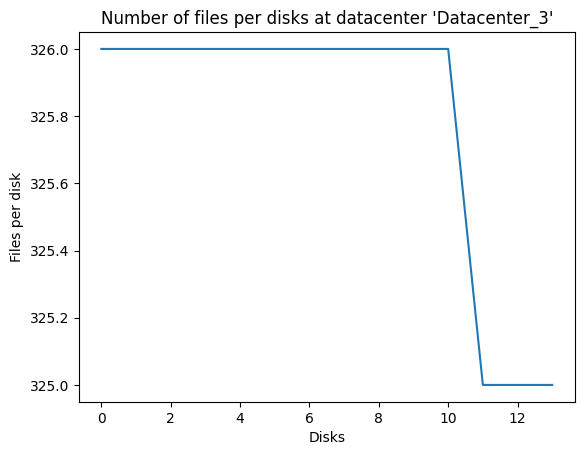

Disk ID '50' at datacenter 'Datacenter_4' has 186 stored files.
Disk ID '51' at datacenter 'Datacenter_4' has 184 stored files.
Disk ID '52' at datacenter 'Datacenter_4' has 156 stored files.
Disk ID '53' at datacenter 'Datacenter_4' has 138 stored files.
Disk ID '54' at datacenter 'Datacenter_4' has 154 stored files.
Disk ID '55' at datacenter 'Datacenter_4' has 175 stored files.
Disk ID '56' at datacenter 'Datacenter_4' has 208 stored files.
Disk ID '57' at datacenter 'Datacenter_4' has 325 stored files.
Disk ID '58' at datacenter 'Datacenter_4' has 325 stored files.
Disk ID '59' at datacenter 'Datacenter_4' has 325 stored files.
Disk ID '60' at datacenter 'Datacenter_4' has 325 stored files.
Disk ID '61' at datacenter 'Datacenter_4' has 325 stored files.
Disk ID '62' at datacenter 'Datacenter_4' has 325 stored files.
Disk ID '63' at datacenter 'Datacenter_4' has 325 stored files.


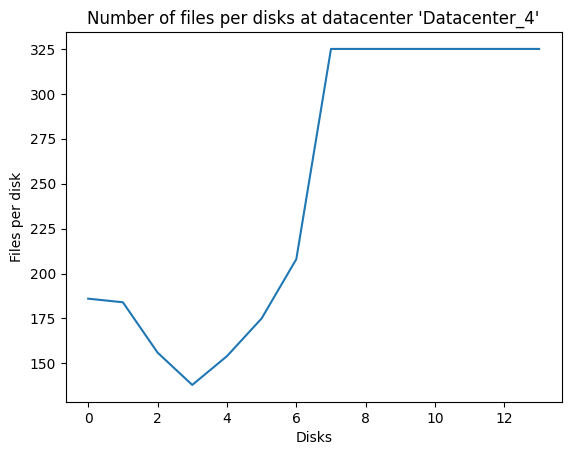

3358.0 stored files at datacenter 'Datacenter_1'.
4564.0 stored files at datacenter 'Datacenter_2'.
4561.0 stored files at datacenter 'Datacenter_3'.
3476.0 stored files at datacenter 'Datacenter_4'.
The cloud provider has 15959.0 stored files.


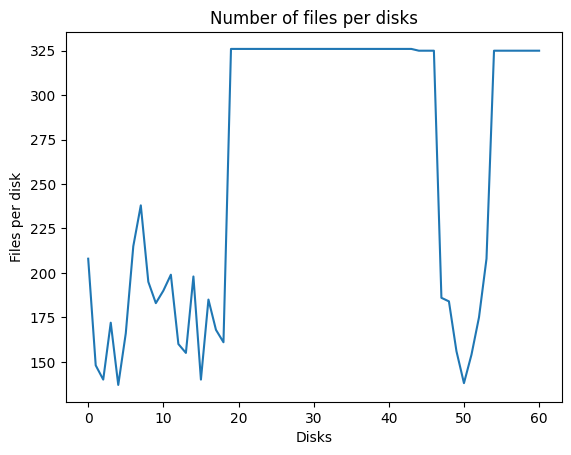

The number of powered down disks: 0


In [324]:
labels = np.unique(dataset['datacenter_name'])
max_limit = 1
min_limit = 0.95

duration = dataset['duration'][0]
files_per_datacenter = np.array([])
files_per_host = np.array([])
num_powered_down_disk = 0

max_power_per_disk = np.array([])
max_power_per_disk_duration = np.array([])
max_power_per_datacenter = np.array([])
max_power_per_datacenter_duration = np.array([])
current_power_per_disk = np.array([])
current_power_per_disk_duration = np.array([])
current_power_per_datacenter = np.array([])
current_power_per_datacenter_duration = np.array([])

datacenter_total_capacity = np.array([])
datacenter_total_duration = np.array([])

datacenter_disks = np.array([])
datacenter_disks_overutilized = np.array([])
datacenter_disks_underutilized = np.array([])
datacenter_current_disks_powered_on = np.array([])
datacenter_current_disks_powered_off = np.array([])

# datacenter_current_available_capacity = np.array([])
datacenter_current_used_capacity = np.array([])
datacenter_current_used_active_duration = np.array([])
datacenter_current_used_idle_duration = np.array([])

for i in range(len(labels)):
    files_per_datacenter_per_host = np.array([])
    
    under_utilized = 0
    over_utilized = 0
    
    max_capacity = 0
    max_duration = 0
    available_capacity = 0
    used_capacity = 0
    current_active_duration = 0
    current_idle_duration = 0
    
    disks = 0
    disks_power_on = 0
    disks_power_off = 0
    
    max_power = 0
    max_power_duration = 0
    current_power = 0
    current_power_duration = 0
    
    for index, sample in dataset[dataset['datacenter_name'] == labels[i]].iterrows():
        if pd.notna(sample['files']):
            files = len(sample['files'].split(":")) - 1
            files_per_host = np.append(files_per_host, len(sample['files'].split(":")) - 1)
            files_per_datacenter_per_host = np.append(files_per_datacenter_per_host, len(sample['files'].split(":")) - 1)
            print(f"Disk ID '{sample['storage_id']}' at datacenter '{sample['datacenter_name']}' has {files} stored files.")
        
        max_power += sample['active_power']
        max_power_duration += sample['active_power'] * sample['duration']
        
        disks += 1
        
        max_capacity += sample['storage_capacity']
        max_duration += sample['duration']
        
        
        
        current_power_duration += float(sample['active_power']) * float(sample['active_duration']) + float(sample['idle_power']) * (float(sample['duration']) - float(sample['active_duration']))
        if sample['is_active'] == True or float(sample['active_duration']) > 0:
            disks_power_on += 1
            current_power += float(sample['active_power'])
            # available_capacity += (sample['storage_capacity'] - sample['capacity_used'])
            used_capacity += sample['capacity_used']
            current_active_duration += sample['active_duration']
            current_idle_duration += (sample['duration'] - sample['active_duration'])
            
            if sample['capacity_used'] / sample['storage_capacity'] < min_limit:
                under_utilized += 1
            elif sample['capacity_used'] / sample['storage_capacity'] > max_limit:
                over_utilized += 1
        elif sample['is_active'] == False:
            disks_power_on += 1
            current_power += float(sample['idle_power'])
            # available_capacity += (sample['storage_capacity'] - sample['capacity_used'])
            used_capacity += sample['capacity_used']
            current_active_duration += sample['active_duration']
            current_idle_duration += (sample['duration'] - sample['active_duration'])
            
            if sample['capacity_used'] / sample['storage_capacity'] < min_limit:
                under_utilized += 1
            elif sample['capacity_used'] / sample['storage_capacity'] > max_limit:
                over_utilized += 1
        else:
            num_powered_down_disk += 1
            disks_power_off += 1
            # available_capacity += 0
            used_capacity += sample['storage_capacity']
        
        
    files_per_datacenter = np.append(files_per_datacenter, np.sum(files_per_datacenter_per_host))
    
    max_power_per_datacenter = np.append(max_power_per_datacenter, max_power)
    max_power_per_datacenter_duration = np.append(max_power_per_datacenter_duration, max_power_duration)
    current_power_per_datacenter = np.append(current_power_per_datacenter, current_power)
    current_power_per_datacenter_duration = np.append(current_power_per_datacenter_duration, current_power_duration)
    
    datacenter_total_capacity = np.append(datacenter_total_capacity, max_capacity)
    datacenter_total_duration = np.append(datacenter_total_duration, max_duration)
    
    datacenter_disks = np.append(datacenter_disks, disks)
    datacenter_disks_overutilized = np.append(datacenter_disks_overutilized, over_utilized)
    datacenter_disks_underutilized = np.append(datacenter_disks_underutilized, under_utilized)
    datacenter_current_disks_powered_on = np.append(datacenter_current_disks_powered_on, disks_power_on)
    datacenter_current_disks_powered_off = np.append(datacenter_current_disks_powered_off, disks_power_off)
    
    # datacenter_current_available_capacity = np.append(datacenter_current_available_capacity, available_capacity)
    datacenter_current_used_capacity = np.append(datacenter_current_used_capacity, used_capacity)
    datacenter_current_used_active_duration = np.append(datacenter_current_used_active_duration, current_active_duration)
    datacenter_current_used_idle_duration = np.append(datacenter_current_used_idle_duration, current_idle_duration)
    
    plt.plot(np.arange(len(files_per_datacenter_per_host)), files_per_datacenter_per_host, label="Files per disk")
    plt.xlabel("Disks")
    plt.ylabel("Files per disk")
    plt.title(f"Number of files per disks at datacenter '{labels[i]}'")
    #plt.legend()
    plt.show()
for i in range(len(labels)):
    print(f"{files_per_datacenter[i]} stored files at datacenter '{labels[i]}'.")
print(f"The cloud provider has {np.sum(files_per_datacenter)} stored files.")

plt.plot(np.arange(len(files_per_host)), files_per_host, label="Files per disk")
plt.xlabel("Disks")
plt.ylabel("Files per disk")
plt.title("Number of files per disks")
#plt.legend()
plt.show()

print(f"The number of powered down disks: {num_powered_down_disk}")


#### Capacity aware data placement 

In [325]:
disks = []
files = []
for i, sample in dataset.iterrows():
    disks.append({
        "id": i,
        "datacenter": sample['datacenter_name'],
        "storage_capacity": float(sample['storage_capacity']),
        "capacity_used": float(sample['capacity_used']),
        "max_internal_data_transfer_rate": float(sample['max_internal_data_transfer_rate']),
        "is_active": bool(sample['is_active']),
        "active_duration": float(sample['active_duration']),
        "active_power": float(sample['active_power']),
        "idle_power": float(sample['idle_power'])

    })
    if pd.notna(sample['files']):
        for j, file in enumerate(sample['files'].split(":")):
            file_data = file.split(",")
            if len(file_data) != 3:
                continue
            files.append({
                "id": j,
                "filename": file_data[0],
                "filesize": float(file_data[1]),
                "transaction_time": float(file_data[2])
            })

files_copy = files.copy()
new_storage_placement = []
removed_files_from_copy = 0

for index_disk, disk in enumerate(disks):
    used_storage = 0
    files_per_disk = []
    for file in files_copy:
        temp_utilization = ((file['filesize'] + used_storage) / disk['storage_capacity'])
        if temp_utilization <= min_limit and temp_utilization <= max_limit:
            # Updating file transaction time for the disk
            # Formula from CloudSimDisk (add to thesis)
            seek_time = file['filesize'] / disk['storage_capacity']
            transfer_time =  (file['filesize'] * disk['max_internal_data_transfer_rate']) / disk['storage_capacity']
            file['transaction_time'] = seek_time + transfer_time
            
            used_storage += file['filesize']
            files_per_disk.append(file)
    
    # Adding to new list of placement of data and removing from the copy 
    new_storage_placement.append(files_per_disk)
    for index, file in enumerate(files_per_disk):
        run = True
        index = 0
        while run:
            if file['id'] == files_copy[index]['id']:
                del files_copy[index]
                run = False
            index += 1
    
    disk['capacity_used'] = used_storage
    if len(files_per_disk) == 0 or used_storage == 0:
        disk['is_active'] = False
        disk['active_duration'] = 0
    else:
        disk['is_active'] = True


Disk ID '0' has 186 stored files with capacity (854528.0/900000.0) as supposed to (854528.0/900000.0),
consuming the 1662.7215928888886 over the duration 377.8912711111111s,
where the disk was idle for 188.94563555555558 which could have saved 566.8369066666668 if powered off.

Disk ID '1' has 149 stored files with capacity (854528.0/900000.0) as supposed to (854528.0/900000.0),
consuming the 1662.7215928888886 over the duration 377.8912711111111s,
where the disk was idle for 188.94563555555558 which could have saved 566.8369066666668 if powered off.

Disk ID '2' has 137 stored files with capacity (854528.0/900000.0) as supposed to (854528.0/900000.0),
consuming the 1662.721592888889 over the duration 377.8912711111111s,
where the disk was idle for 188.94563555555553 which could have saved 566.8369066666666 if powered off.

Disk ID '3' has 170 stored files with capacity (854528.0/900000.0) as supposed to (854528.0/900000.0),
consuming the 1662.7215928888882 over the duration 377.891271

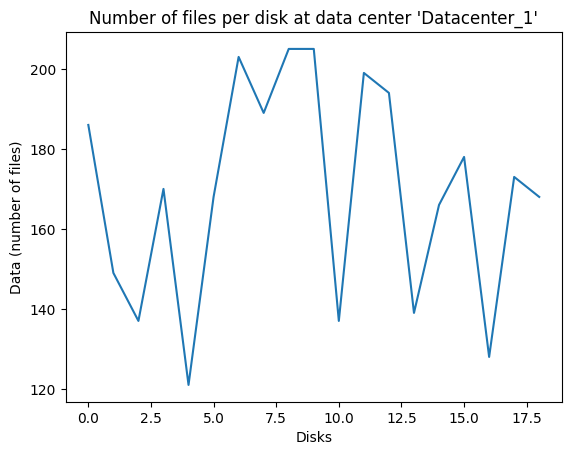

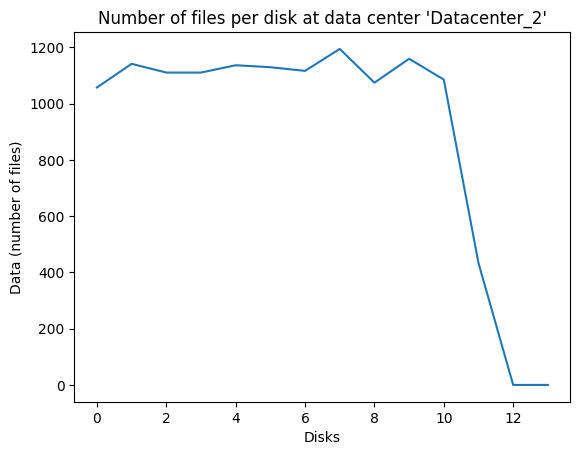

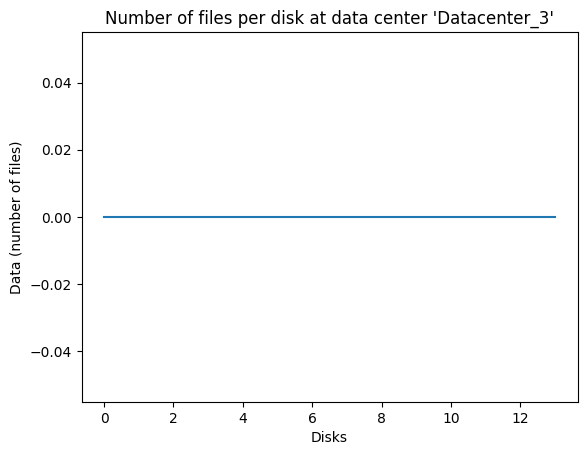

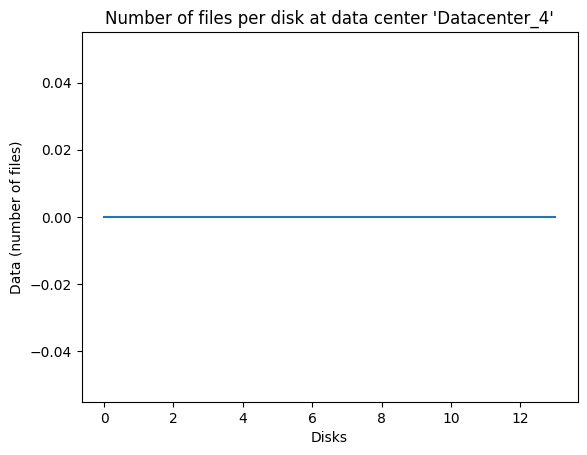

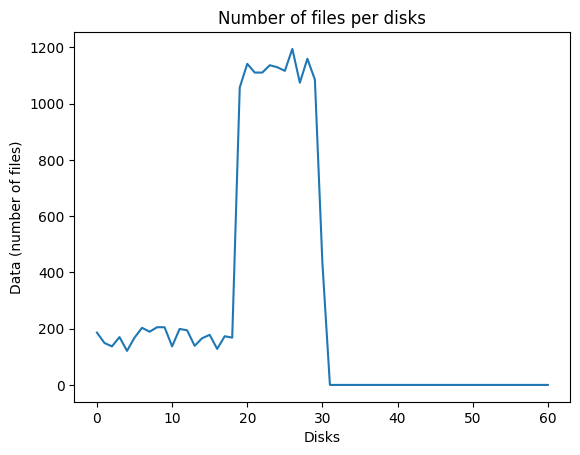

In [326]:
datacenter_new_placement_disks_powered_on = np.zeros(len(labels))
datacenter_new_placement_disks_powered_off = np.zeros(len(labels))
datacenter_new_placement_disk_power = np.zeros(len(labels))
datacenter_new_placement_disk_max_power_consumed = np.zeros(len(labels))
datacenter_new_placement_disk_power_consumed = np.zeros(len(labels))

datacenter_new_placement_files = np.zeros(len(labels))
datacenter_new_placement_overutilized = np.zeros(len(labels))
datacenter_new_placement_underutilized = np.zeros(len(labels))
datacenter_new_placement_used_capacity = np.zeros(len(labels))
datacenter_new_placement_used_or_unavailable_capacity = np.zeros(len(labels))
datacenter_new_placement_used_total_time = np.zeros(len(labels))
datacenter_new_placement_used_active_duration = np.zeros(len(labels))
datacenter_new_placement_used_idle_duration = np.zeros(len(labels))



# Getting new duration
new_placement_max_time = 0
for index_disk, disk in enumerate(new_storage_placement):
    datacenter_index = np.where(disks[index_disk]['datacenter'] == labels)[0][0]
    transaction_time = 0
    for index_file, file in enumerate(disk):
        # Updating file transaction time for the disk
        # Formula from CloudSimDisk (add to thesis)
        # seek_time = file['filesize'] / disks[index_disk]['storage_capacity']
        # transfer_time =  (file['filesize'] * disks[index_disk]['max_internal_data_transfer_rate']) / disks[index_disk]['storage_capacity']
        # file['transaction_time'] = seek_time + transfer_time
        transaction_time += file['transaction_time']
    if transaction_time > new_placement_max_time:
        new_placement_max_time += transaction_time

# Calculating the capacity used per disk and power consumption.
new_data_placement_per_disk = np.array([])
new_data_placement_per_datacenter_per_disk = {}
for index_disk, disk in enumerate(new_storage_placement):
    transaction_time = 0
    capacity_used = 0
    files = len(disk)
    datacenter_index = np.where(disks[index_disk]['datacenter'] == labels)[0][0]
    
    for index_file, file in enumerate(disk):
        capacity_used += file['filesize']
        transaction_time += file['transaction_time']
    
    
    new_data_placement_per_disk = np.append(new_data_placement_per_disk, files)
    if disks[index_disk]['datacenter'] not in new_data_placement_per_datacenter_per_disk.keys():
        # print(new_data_placement_per_datacenter_per_disk[hosts[index_host]['datacenter']])
        new_data_placement_per_datacenter_per_disk[disks[index_disk]['datacenter']] = np.array([])
    new_data_placement_per_datacenter_per_disk[disks[index_disk]['datacenter']] = np.append(new_data_placement_per_datacenter_per_disk[disks[index_disk]['datacenter']], files)
    
    datacenter_new_placement_files[datacenter_index] += files
    datacenter_new_placement_disk_max_power_consumed[datacenter_index] += new_placement_max_time * disks[index_disk]['active_power']
    
    if capacity_used == 0 or disks[index_disk]['is_active'] == False:
        datacenter_new_placement_disks_powered_off[datacenter_index] += 1
        datacenter_new_placement_used_or_unavailable_capacity[datacenter_index] += disks[index_disk]['storage_capacity']
    else:
        datacenter_new_placement_disks_powered_on[datacenter_index] += 1
        datacenter_new_placement_used_capacity[datacenter_index] += capacity_used
        datacenter_new_placement_used_or_unavailable_capacity[datacenter_index] += capacity_used
        
        datacenter_new_placement_used_active_duration[datacenter_index] += transaction_time
        datacenter_new_placement_used_idle_duration[datacenter_index] += new_placement_max_time - transaction_time
        datacenter_new_placement_used_total_time[datacenter_index] += new_placement_max_time
        
        if transaction_time > 0:
            datacenter_new_placement_disk_power[datacenter_index] += disks[index_disk]['active_power']
            datacenter_new_placement_disk_power_consumed[datacenter_index] += disks[index_disk]['active_power'] * transaction_time
        
        if capacity_used / disks[index_disk]['storage_capacity'] < min_limit:
            datacenter_new_placement_underutilized[datacenter_index] += 1
        elif capacity_used / disks[index_disk]['storage_capacity'] > max_limit:
            datacenter_new_placement_overutilized[datacenter_index] += 1
        
    
    if files != 0:
        print(f"Disk ID '{index_disk}' has {files} stored files with capacity ({capacity_used}/{disks[index_disk]['storage_capacity']}) as supposed to ({disks[index_disk]['capacity_used']}/{disks[index_disk]['storage_capacity']}),\nconsuming the {(disks[index_disk]['active_power']*transaction_time) + (disks[index_disk]['idle_power']*(new_placement_max_time - transaction_time))} over the duration {new_placement_max_time}s,\nwhere the disk was idle for {new_placement_max_time - transaction_time} which could have saved {disks[index_disk]['idle_power']*(new_placement_max_time - transaction_time)} if powered off.\n")
    else:
        print(f"Disk ID '{index_disk}' has {files} stored files with capacity ({capacity_used}/{disks[index_disk]['storage_capacity']}) as supposed to ({disks[index_disk]['capacity_used']}/{disks[index_disk]['storage_capacity']}),\ncan be powered off consuming 0 Joules (J) over the duration {new_placement_max_time}s.\n")

for key in new_data_placement_per_datacenter_per_disk.keys():
    plt.plot(np.arange(len(new_data_placement_per_datacenter_per_disk[key])), new_data_placement_per_datacenter_per_disk[key], label="Files per host")
    plt.xlabel("Disks")
    plt.ylabel("Data (number of files)")
    plt.title(f"Number of files per disk at data center '{key}'")
    #plt.legend()
    plt.savefig(f"../figs/storage/storage_placement/{key.lower()}_simple_capacity_aware_placement.eps", format="eps")
    plt.show()

plt.plot(np.arange(len(new_data_placement_per_disk)), new_data_placement_per_disk, label="Files per host")
plt.xlabel("Disks")
plt.ylabel("Data (number of files)")
plt.title("Number of files per disks")
#plt.legend()
plt.savefig(f"../figs/storage/storage_placement/cloud_provider_simple_capacity_aware_placement.eps", format="eps")
plt.show()

#### Optimal capacity aware storage placement 

### Re-organization of file placement

Rebalancing over utilized and under utilized disk capacity with the goal if better utilizing the storage area network.

In [327]:
labels = np.unique(dataset['datacenter_name'])
files_reorganized = []
disks_reorganized = []

files_to_reallocate = np.array([])
over_utilized_disks = 0
under_utilized_disks = 0

for i in range(len(labels)):
    for index, sample in dataset[dataset['datacenter_name'] == labels[i]].iterrows():
        files_temp = []
        if pd.notna(sample['files']):
            for index_file, file in enumerate(sample['files'].split(":")):
                    if file != "":
                        file_data = file.split(",")
                        files_temp.append({
                            "id": index_file,
                            "filename": file_data[0],
                            "filesize": float(file_data[1]),
                            "transaction_time": float(file_data[2])
                        })
        
        # check if disk is over utilized
        capacity_utilization = sample['capacity_used'] / sample['storage_capacity']
        
        if capacity_utilization > max_limit:
            over_utilized_disks += 1
            if pd.notna(sample['files']):
                temp_capacity_used = sample['capacity_used']
                
                run = True
                for index_file, file in enumerate(sample['files'].split(":")):
                    if run == True and file != "":
                        file_data = file.split(",")
                        capacity_utilization = (sample['capacity_used'] - float(file_data[1])) / sample['storage_capacity']
                        
                        
                        if capacity_utilization >= min_limit and capacity_utilization <= max_limit:
                            temp_capacity_used -= float(file_data[1])
                            files_to_reallocate = np.append(files_to_reallocate, files_temp[index_file])
                            del files_temp[index_file]
                            
                            run = False
                sample['capacity_used'] = temp_capacity_used
        elif capacity_utilization == 0:
            pass
        elif capacity_utilization < min_limit:
            under_utilized_disks += 1
            
    
        disks_reorganized.append({
            "id": i,
            "datacenter": sample['datacenter_name'],
            "storage_capacity": float(sample['storage_capacity']),
            "capacity_used": float(sample['capacity_used']),
            "max_internal_data_transfer_rate": float(sample['max_internal_data_transfer_rate']),
            "is_active": bool(sample['is_active']),
            "active_duration": float(sample['active_duration']),
            "active_power": float(sample['active_power']),
            "idle_power": float(sample['idle_power']),
            "files": files_temp
        })
print(f"There were {over_utilized_disks} over utilized disks")
print(f"There were {under_utilized_disks} under utilized disks")

# Re allocating files
for disk in disks_reorganized:
    capacity_utilization = disk['capacity_used'] / disk['storage_capacity']
    new_capacity_used = disk['capacity_used']
    new_allocated_files = disk['files']
    
    if capacity_utilization < min_limit:
        for index_file, file in enumerate(files_to_reallocate):
            temp_capacity_used = new_capacity_used
            temp_capacity_used += file['filesize']
            if (temp_capacity_used / disk['storage_capacity']) <= min_limit and (temp_capacity_used / disk['storage_capacity']) <= max_limit:
                new_capacity_used += file['filesize']
                new_allocated_files.append(file)
                files_to_reallocate.remove(file)
        disk['capacity_used'] = new_capacity_used
        disk['files'] = new_allocated_files
    
    if disk['capacity_used'] != 0 or disk['active_duration'] > 0:
        disk['is_active'] = True
        

# consolidate under utilized disks
underutilized_disk = None
num_new_reorganized_powered_down_disk = 0
for disk in disks_reorganized:
    capacity_utilization = disk['capacity_used'] / disk['storage_capacity']
    if capacity_utilization < min_limit:
        if underutilized_disk == None:
            underutilized_disk = disk
            continue
        else:
            # moving files from one disk to another
            temp_underutilized_disk_new_allocated_files = underutilized_disk['files'].copy()
            temp_current_disk_new_allocated_files = disk['files'].copy()
            
            temp_underutilized_disk_capacity_used = underutilized_disk['capacity_used']
            temp_current_disk_capacity_used = disk['capacity_used']
            
            for index_file, file in enumerate(disk['files']):
                if ((temp_underutilized_disk_capacity_used + file['filesize']) / underutilized_disk['storage_capacity']) < min_limit and ((temp_underutilized_disk_capacity_used + file['filesize']) / underutilized_disk['storage_capacity']) <= max_limit:
                    temp_underutilized_disk_capacity_used += file['filesize']
                    temp_underutilized_disk_new_allocated_files.append(file)
                    
                    temp_current_disk_capacity_used -= file['filesize']
                    temp_current_disk_new_allocated_files.remove(file)
            
            underutilized_disk['capacity_used'] = temp_underutilized_disk_capacity_used
            underutilized_disk['files'] = temp_underutilized_disk_new_allocated_files
            
            disk['capacity_used'] = temp_current_disk_capacity_used
            disk['files'] = temp_current_disk_new_allocated_files
            
            if disk['capacity_used'] == 0:
                num_new_reorganized_powered_down_disk += 1
                disk['is_active'] = False
                disk['active_duration'] = 0
                
                if underutilized_disk['capacity_used'] / underutilized_disk['storage_capacity'] >= min_limit:
                    underutilized_disk = disk
            elif disk['capacity_used'] / disk['storage_capacity'] >= min_limit:
                if underutilized_disk['capacity_used'] / underutilized_disk['storage_capacity'] >= min_limit:
                    underutilized_disk = None
            else:
                underutilized_disk = disk

num_new_reorganized_under_utilized_disk = 0
num_new_reorganized_over_utilized_disk = 0

datacenter_reorganized_placement_disks_powered_on = np.zeros(len(labels))
datacenter_reorganized_placement_disks_powered_off = np.zeros(len(labels))
datacenter_reorganized_placement_disk_power = np.zeros(len(labels))
datacenter_reorganized_placement_disk_max_power_consumed = np.zeros(len(labels))
datacenter_reorganized_placement_disk_power_consumed = np.zeros(len(labels))

datacenter_reorganized_placement_files = np.zeros(len(labels))
datacenter_reorganized_placement_used_capacity = np.zeros(len(labels))
datacenter_reorganized_placement_used_or_unavailable_capacity = np.zeros(len(labels))
datacenter_reorganized_placement_used_total_time = np.zeros(len(labels))
datacenter_reorganized_placement_used_active_duration = np.zeros(len(labels))
datacenter_reorganized_placement_used_idle_duration = np.zeros(len(labels))

datacenter_reorganized_placement_underutilized = np.zeros(len(labels))
datacenter_reorganized_placement_overutilized = np.zeros(len(labels))
# Getting new duration
reorganized_placement_max_time = 0
for disk in disks_reorganized:
    datacenter_index = np.where(disk['datacenter'] == labels)[0][0]
    transaction_time = 0
    for index_file, file in enumerate(disk['files']):
        # Updating file transaction time for the disk
        # Formula from CloudSimDisk (add to thesis)
        seek_time = file['filesize'] / disk['storage_capacity']
        transfer_time =  (file['filesize'] * disk['max_internal_data_transfer_rate']) / disk['storage_capacity']
        file['transaction_time'] = seek_time + transfer_time
        transaction_time += file['transaction_time']
    if transaction_time > reorganized_placement_max_time:
        reorganized_placement_max_time += transaction_time

for disk in disks_reorganized:
    disk_utilization = disk['capacity_used'] / disk['storage_capacity']
    # if disk['is_active'] == False:
    #     print(disk['is_active'])
    #     print(disk['capacity_used'])
    #     print(disk_utilization)
    if disk_utilization != 0 and disk_utilization < min_limit:
        num_new_reorganized_under_utilized_disk += 1
        datacenter_reorganized_placement_underutilized[datacenter_index] += 1
    elif disk_utilization != 0 and disk_utilization > max_limit:
        num_new_reorganized_over_utilized_disk += 1
        datacenter_reorganized_placement_overutilized[datacenter_index] += 1
    
    datacenter_index = np.where(disk['datacenter'] == labels)[0][0]
    datacenter_reorganized_placement_disk_max_power_consumed[datacenter_index] += reorganized_placement_max_time * disk['active_power']
    if disk['is_active'] == False or disk['capacity_used'] == 0 or disk['active_duration'] == 0:
        datacenter_reorganized_placement_disks_powered_off[datacenter_index] += 1
        datacenter_reorganized_placement_used_or_unavailable_capacity[datacenter_index] += disk['storage_capacity']
    else:
        datacenter_reorganized_placement_disks_powered_on[datacenter_index] += 1
        datacenter_reorganized_placement_files[datacenter_index] += len(disk['files'])
        datacenter_reorganized_placement_used_capacity[datacenter_index] += disk['capacity_used']
        datacenter_reorganized_placement_used_or_unavailable_capacity[datacenter_index] += disk['capacity_used']
        datacenter_reorganized_placement_disk_power[datacenter_index] += disk['active_power']
        
        disk_active_duration = 0
        for file in disk['files']:
            disk_active_duration += file['transaction_time']
        datacenter_reorganized_placement_used_total_time += reorganized_placement_max_time
        datacenter_reorganized_placement_used_active_duration += disk_active_duration
        datacenter_reorganized_placement_used_idle_duration += (reorganized_placement_max_time - disk_active_duration)
    

There were 0 over utilized disks
There were 35 under utilized disks


### Comparing

In [328]:
print("New placement:")
print(f"New total collective duration {np.sum(datacenter_new_placement_used_total_time)}")
print(f"Out of the {np.sum(datacenter_disks)} available disks {np.sum(datacenter_new_placement_disks_powered_on)} could be are powered on and {np.sum(datacenter_new_placement_disks_powered_off)} disks could powered down. (percent: {(np.sum(datacenter_new_placement_disks_powered_on)/np.sum(datacenter_disks))*100}%)")
print(f"Out of the {np.sum(datacenter_disks)} available disks {np.sum(datacenter_new_placement_overutilized)} would be over utilized. (percent: {(np.sum(datacenter_new_placement_overutilized)/np.sum(datacenter_disks))*100}%)")
print(f"Out of the {np.sum(datacenter_disks)} available disks {np.sum(datacenter_new_placement_underutilized)} would be under utilized. (percent: {(np.sum(datacenter_new_placement_underutilized)/np.sum(datacenter_disks))*100}%)")
print(f"Out of the {np.sum(datacenter_total_capacity)} available capacity {np.sum(datacenter_new_placement_used_capacity)} are used. (percent: {((np.sum(datacenter_new_placement_used_capacity))/np.sum(datacenter_total_capacity))*100}%)")
print(f"Out of the {np.sum(datacenter_total_capacity)} available capacity {np.sum(datacenter_new_placement_used_or_unavailable_capacity)} are used or unavailable. (percent: {((np.sum(datacenter_new_placement_used_or_unavailable_capacity))/np.sum(datacenter_total_capacity))*100}%)")
print(f"With a total active duration of all disks {np.sum(datacenter_new_placement_used_active_duration)} out of a total duration between all disks {np.sum(datacenter_new_placement_used_total_time)}. (percent: {((np.sum(datacenter_new_placement_used_active_duration))/np.sum(datacenter_new_placement_used_total_time))*100}%)")
print(f"With a total inactive duration of all disks {np.sum(datacenter_new_placement_used_idle_duration)} out of a total duration between all disks {np.sum(datacenter_new_placement_used_total_time)}. (percent: {((np.sum(datacenter_new_placement_used_idle_duration))/np.sum(datacenter_new_placement_used_total_time))*100}%)")
print()

print("Reorganized placement:")
print(f"New total collective duration {np.sum(datacenter_reorganized_placement_used_total_time)}")
print(f"Out of the {np.sum(datacenter_disks)} available disks {np.sum(datacenter_reorganized_placement_disks_powered_on)} could be are powered on and {np.sum(datacenter_reorganized_placement_disks_powered_off)} disks could powered down. (percent: {(np.sum(datacenter_reorganized_placement_disks_powered_on)/np.sum(datacenter_disks))*100}%)")
print(f"Out of the {np.sum(datacenter_disks)} available disks {np.sum(datacenter_reorganized_placement_overutilized)} would be over utilized. (percent: {(np.sum(datacenter_reorganized_placement_overutilized)/np.sum(datacenter_disks))*100}%)")
print(f"Out of the {np.sum(datacenter_disks)} available disks {np.sum(datacenter_reorganized_placement_underutilized)} would be under utilized. (percent: {(np.sum(datacenter_reorganized_placement_underutilized)/np.sum(datacenter_disks))*100}%)")
print(f"Out of the {np.sum(datacenter_total_capacity)} available capacity {np.sum(datacenter_reorganized_placement_used_capacity)} are used. (percent: {((np.sum(datacenter_reorganized_placement_used_capacity))/np.sum(datacenter_total_capacity))*100}%)")
print(f"Out of the {np.sum(datacenter_total_capacity)} available capacity {np.sum(datacenter_reorganized_placement_used_or_unavailable_capacity)} are used or unavailable. (percent: {((np.sum(datacenter_reorganized_placement_used_or_unavailable_capacity))/np.sum(datacenter_total_capacity))*100}%)")
if int(np.sum(datacenter_reorganized_placement_used_total_time)) != 0:
    print(f"With a total active duration of all disks {np.sum(datacenter_reorganized_placement_used_active_duration)} out of a total duration between all disks {np.sum(datacenter_reorganized_placement_used_total_time)}. (percent: {((np.sum(datacenter_reorganized_placement_used_active_duration))/np.sum(datacenter_reorganized_placement_used_total_time))*100}%)")
    print(f"With a total inactive duration of all disks {np.sum(datacenter_reorganized_placement_used_idle_duration)} out of a total duration between all disks {np.sum(datacenter_reorganized_placement_used_total_time)}. (percent: {((np.sum(datacenter_reorganized_placement_used_idle_duration))/np.sum(datacenter_reorganized_placement_used_total_time))*100}%)")
else:
    print(f"With a total active duration of all disks {np.sum(datacenter_reorganized_placement_used_active_duration)} out of a total duration between all disks {np.sum(datacenter_reorganized_placement_used_total_time)}. (percent: {0}%)")
    print(f"With a total inactive duration of all disks {np.sum(datacenter_reorganized_placement_used_idle_duration)} out of a total duration between all disks {np.sum(datacenter_reorganized_placement_used_total_time)}. (percent: {0}%)")
print()

print("Compared to:")
print(f"Previous total collective duration {np.sum(datacenter_total_duration)}")
print(f"Out of the {np.sum(datacenter_disks)} available disks {np.sum(datacenter_current_disks_powered_on)} are powered on and {np.sum(datacenter_current_disks_powered_off)} hosts are powered down. (percent: {(np.sum(datacenter_current_disks_powered_off)/np.sum(datacenter_disks))*100}%)")
print(f"Out of the {np.sum(datacenter_disks)} available disks {np.sum(datacenter_disks_overutilized)} are over utilized. (percent: {(np.sum(datacenter_disks_overutilized)/np.sum(datacenter_disks))*100}%)")
print(f"Out of the {np.sum(datacenter_disks)} available disks {np.sum(datacenter_disks_underutilized)} are under utilized. (percent: {(np.sum(datacenter_disks_underutilized)/np.sum(datacenter_disks))*100}%)")
print(f"Out of the {np.sum(datacenter_total_capacity)} available capacity {np.sum(datacenter_current_used_capacity)} are used. (percent: {((np.sum(datacenter_current_used_capacity))/np.sum(datacenter_total_capacity))*100}%)")
print(f"With a total active duration of all disks {np.sum(datacenter_current_used_active_duration)} out of a total duration between all disks {np.sum(datacenter_total_duration)}. (percent: {((np.sum(datacenter_current_used_active_duration))/np.sum(datacenter_total_duration))*100}%)")
print(f"With a total inactive duration of all disks {np.sum(datacenter_current_used_idle_duration)} out of a total duration between all disks {np.sum(datacenter_total_duration)}. (percent: {((np.sum(datacenter_current_used_idle_duration))/np.sum(datacenter_total_duration))*100}%)")

New placement:
New total collective duration 11714.629404444448
Out of the 61.0 available disks 31.0 could be are powered on and 30.0 disks could powered down. (percent: 50.81967213114754%)
Out of the 61.0 available disks 0.0 would be over utilized. (percent: 0.0%)
Out of the 61.0 available disks 31.0 would be under utilized. (percent: 50.81967213114754%)
Out of the 217400000.0 available capacity 81367552.0 are used. (percent: 37.42757681692732%)
Out of the 217400000.0 available capacity 209667552.0 are used or unavailable. (percent: 96.44321619135235%)
With a total active duration of all disks 5945.557048888916 out of a total duration between all disks 11714.629404444448. (percent: 50.75326622482154%)
With a total inactive duration of all disks 5769.072355555529 out of a total duration between all disks 11714.629404444448. (percent: 49.24673377517844%)

Reorganized placement:
New total collective duration 58876.77326222222
Out of the 61.0 available disks 37.0 could be are powered on a

In [329]:
for index in range(len(labels)):
    print(f"---------- {labels[index]} ----------")
    print("New placement:")
    print(f"New total collective duration {datacenter_new_placement_used_total_time[index]}")
    print(f"Out of the total {np.sum(datacenter_new_placement_files)} files the datacenter has {datacenter_new_placement_files[index]} files")
    print(f"Out of the {datacenter_disks[index]} available disks {datacenter_new_placement_overutilized[index]} would be over utilized. (percent: {(datacenter_new_placement_overutilized[index]/datacenter_disks[index])*100}%)")
    print(f"Out of the {datacenter_disks[index]} available disks {datacenter_new_placement_underutilized[index]} would be under utilized. (percent: {(datacenter_new_placement_underutilized[index]/datacenter_disks[index])*100}%)")
    print(f"Out of the {datacenter_disks[index]} available disks {datacenter_new_placement_disks_powered_on[index]} could be are powered on and {datacenter_new_placement_disks_powered_off[index]} disks could powered down. (percent: {(datacenter_new_placement_disks_powered_on[index]/datacenter_disks[index])*100}%)")
    print(f"Out of the {datacenter_total_capacity[index]} available capacity {datacenter_new_placement_used_capacity[index]} are used. (percent: {((datacenter_new_placement_used_capacity[index])/datacenter_total_capacity[index])*100}%)")
    print(f"Out of the {datacenter_total_capacity[index]} available capacity {datacenter_new_placement_used_or_unavailable_capacity[index]} are used or unavailable. (percent: {((datacenter_new_placement_used_or_unavailable_capacity[index])/datacenter_total_capacity[index])*100}%)")
    if int(datacenter_new_placement_used_total_time[index]) != 0:
        print(f"With a total active duration of all disks {datacenter_new_placement_used_active_duration[index]} out of a total duration between all disks {datacenter_new_placement_used_total_time[index]}. (percent: {((datacenter_new_placement_used_active_duration[index])/datacenter_new_placement_used_total_time[index])*100}%)")
        print(f"With a total inactive duration of all disks {datacenter_new_placement_used_idle_duration[index]} out of a total duration between all disks {datacenter_new_placement_used_total_time[index]}. (percent: {((datacenter_new_placement_used_idle_duration[index])/datacenter_new_placement_used_total_time[index])*100}%)")
    else:
        print(f"With a total active duration of all disks {datacenter_new_placement_used_active_duration[index]} out of a total duration between all disks {datacenter_new_placement_used_total_time[index]}. (percent: {0}%)")
        print(f"With a total inactive duration of all disks {datacenter_new_placement_used_idle_duration[index]} out of a total duration between all disks {datacenter_new_placement_used_total_time[index]}. (percent: {0}%)")
    print()
    
    print("Reorganized placement:")
    print(f"New total collective duration {datacenter_reorganized_placement_used_total_time[index]}")
    print(f"Out of the total {np.sum(datacenter_reorganized_placement_files)} files the datacenter has {datacenter_reorganized_placement_files[index]} files")
    print(f"Out of the {datacenter_disks[index]} available disks {datacenter_reorganized_placement_disks_powered_on[index]} could be are powered on and {datacenter_reorganized_placement_disks_powered_off[index]} disks could powered down. (percent: {(datacenter_reorganized_placement_disks_powered_on[index]/datacenter_disks[index])*100}%)")
    print(f"Out of the {datacenter_disks[index]} available disks {datacenter_reorganized_placement_overutilized[index]} would be over utilized. (percent: {(datacenter_reorganized_placement_overutilized[index]/datacenter_disks[index])*100}%)")
    print(f"Out of the {datacenter_disks[index]} available disks {datacenter_reorganized_placement_underutilized[index]} would be under utilized. (percent: {(datacenter_reorganized_placement_underutilized[index]/datacenter_disks[index])*100}%)")
    print(f"Out of the {datacenter_total_capacity[index]} available capacity {datacenter_reorganized_placement_used_capacity[index]} are used. (percent: {((datacenter_reorganized_placement_used_capacity[index])/datacenter_total_capacity[index])*100}%)")
    print(f"Out of the {datacenter_total_capacity[index]} available capacity {datacenter_reorganized_placement_used_or_unavailable_capacity[index]} are used or unavailable. (percent: {((datacenter_reorganized_placement_used_or_unavailable_capacity[index])/datacenter_total_capacity[index])*100}%)")
    if int(datacenter_reorganized_placement_used_total_time[index]) != 0:
        print(f"With a total active duration of all disks {datacenter_reorganized_placement_used_active_duration[index]} out of a total duration between all disks {datacenter_reorganized_placement_used_total_time[index]}. (percent: {((datacenter_reorganized_placement_used_active_duration[index])/datacenter_reorganized_placement_used_total_time[index])*100}%)")
        print(f"With a total inactive duration of all disks {datacenter_reorganized_placement_used_idle_duration[index]} out of a total duration between all disks {datacenter_reorganized_placement_used_total_time[index]}. (percent: {((datacenter_reorganized_placement_used_idle_duration[index])/datacenter_reorganized_placement_used_total_time[index])*100}%)")
    else:
        print(f"With a total active duration of all disks {datacenter_reorganized_placement_used_active_duration[index]} out of a total duration between all disks {datacenter_reorganized_placement_used_total_time[index]}. (percent: {0}%)")
        print(f"With a total inactive duration of all disks {datacenter_reorganized_placement_used_idle_duration[index]} out of a total duration between all disks {datacenter_reorganized_placement_used_total_time[index]}. (percent: {0}%)")
    print()
    
    print("Compared to:")
    print(f"Previous total collective duration {datacenter_total_duration[index]}")
    print(f"Out of the {datacenter_disks[index]} available disks {datacenter_new_placement_disks_powered_on[index]} are powered on and {datacenter_new_placement_disks_powered_off[index]} hosts are powered down. (percent: {(datacenter_new_placement_disks_powered_on[index]/datacenter_disks[index])*100}%)")
    print(f"Out of the {datacenter_disks[index]} available disks {datacenter_disks_overutilized[index]} would be over utilized. (percent: {(datacenter_disks_overutilized[index]/datacenter_disks[index])*100}%)")
    print(f"Out of the {datacenter_disks[index]} available disks {datacenter_disks_underutilized[index]} would be under utilized. (percent: {(datacenter_disks_underutilized[index]/datacenter_disks[index])*100}%)")
    print(f"Out of the {datacenter_total_capacity[index]} available capacity {datacenter_current_used_capacity[index]} are used. (percent: {((datacenter_current_used_capacity[index])/datacenter_total_capacity[index])*100}%)")
    if int(datacenter_total_duration[index]) != 0:
        print(f"With a total active duration of all disks {datacenter_current_used_active_duration[index]} out of a total duration between all disks {datacenter_total_duration[index]}. (percent: {((datacenter_current_used_active_duration[index])/datacenter_total_duration[index])*100}%)")
        print(f"With a total inactive duration of all disks {datacenter_current_used_idle_duration[index]} out of a total duration between all disks {datacenter_total_duration[index]}. (percent: {((datacenter_current_used_idle_duration[index])/datacenter_total_duration[index])*100}%)")
    else:
        print(f"With a total active duration of all disks {datacenter_current_used_active_duration[index]} out of a total duration between all disks {datacenter_total_duration[index]}. (percent: {0}%)")
        print(f"With a total inactive duration of all disks {datacenter_current_used_idle_duration[index]} out of a total duration between all disks {datacenter_total_duration[index]}. (percent: {0}%)")
    print()

---------- Datacenter_1 ----------
New placement:
New total collective duration 7179.934151111114
Out of the total 15959.0 files the datacenter has 3215.0 files
Out of the 19.0 available disks 0.0 would be over utilized. (percent: 0.0%)
Out of the 19.0 available disks 19.0 would be under utilized. (percent: 100.0%)
Out of the 19.0 available disks 19.0 could be are powered on and 0.0 disks could powered down. (percent: 100.0%)
Out of the 17100000.0 available capacity 16236032.0 are used. (percent: 94.94755555555555%)
Out of the 17100000.0 available capacity 16236032.0 are used or unavailable. (percent: 94.94755555555555%)
With a total active duration of all disks 3589.9670755555567 out of a total duration between all disks 7179.934151111114. (percent: 49.99999999999999%)
With a total inactive duration of all disks 3589.9670755555544 out of a total duration between all disks 7179.934151111114. (percent: 49.999999999999964%)

Reorganized placement:
New total collective duration 14719.1933

Power

In [330]:
print("New placement:")
print("Static:")
print(f"The maximum power consumption for the cloud provider is {np.sum(max_power_per_datacenter)}W")
print(f"The current power consumption for the cloud provider is {np.sum(datacenter_new_placement_disk_power)}W")
print(f"The cloud provider is saving {np.sum(max_power_per_datacenter) - np.sum(datacenter_new_placement_disk_power)}W")
print(f"The cloud provider is thus using {(np.sum(datacenter_new_placement_disk_power) / np.sum(max_power_per_datacenter)) * 100}% of their full power consumption.")
print(f"The cloud provider is thus using {((np.sum(max_power_per_datacenter) - np.sum(datacenter_new_placement_disk_power)) / np.sum(max_power_per_datacenter)) * 100}% of their full power consumption.")
print(f"Duration {new_placement_max_time}:")
print(f"The maximum power consumption for the cloud provider is {np.sum(datacenter_new_placement_disk_max_power_consumed)}W")
print(f"The current power consumption for the cloud provider is {np.sum(datacenter_new_placement_disk_power_consumed)}W")
print(f"The cloud provider is saving {np.sum(datacenter_new_placement_disk_max_power_consumed) - np.sum(datacenter_new_placement_disk_power_consumed)}W")
print(f"The cloud provider is thus using {(np.sum(datacenter_new_placement_disk_power_consumed) / np.sum(datacenter_new_placement_disk_max_power_consumed)) * 100}% of their full power consumption.")
print(f"The cloud provider is thus using {((np.sum(datacenter_new_placement_disk_max_power_consumed) - np.sum(datacenter_new_placement_disk_power_consumed)) / np.sum(datacenter_new_placement_disk_max_power_consumed)) * 100}% of their full power consumption.")
print()
print("Static:")
print(f"The maximum energy consumption for the cloud provider is {(np.sum(max_power_per_datacenter) * 1) / 1000}kJ/s")
print(f"The current energy consumption for the cloud provider is {(np.sum(datacenter_new_placement_disk_power) * 1) / 1000}kJ/s")
print(f"The cloud provider is saving {((np.sum(max_power_per_datacenter) * 1) / 1000) - ((np.sum(datacenter_new_placement_disk_power) * 1) / 1000)}kJ/s")
print(f"The cloud provider is thus using {(((np.sum(datacenter_new_placement_disk_power) * 1) / 1000) / ((np.sum(max_power_per_datacenter) * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
print(f"The cloud provider is saving {((((np.sum(max_power_per_datacenter) - np.sum(datacenter_new_placement_disk_power)) * 1) / 1000) / ((np.sum(max_power_per_datacenter) * 1) / 1000)) * 100}% energy (kJ/s).")
print(f"Duration {new_placement_max_time}:")
print(f"The maximum energy consumption for the cloud provider is {(np.sum(datacenter_new_placement_disk_max_power_consumed) * 1) / 1000}kJ/s")
print(f"The current energy consumption for the cloud provider is {(np.sum(datacenter_new_placement_disk_power_consumed) * 1) / 1000}kJ/s")
print(f"The cloud provider is saving {((np.sum(datacenter_new_placement_disk_max_power_consumed) * 1) / 1000) - ((np.sum(datacenter_new_placement_disk_power_consumed) * 1) / 1000)}kJ/s")
print(f"The cloud provider is thus using {(((np.sum(datacenter_new_placement_disk_power_consumed) * 1) / 1000) / ((np.sum(datacenter_new_placement_disk_max_power_consumed) * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
print(f"The cloud provider is saving {((((np.sum(datacenter_new_placement_disk_max_power_consumed) - np.sum(datacenter_new_placement_disk_power_consumed)) * 1) / 1000) / ((np.sum(datacenter_new_placement_disk_max_power_consumed) * 1) / 1000)) * 100}% energy (kJ/s).")
print()
print()

print("Reorganized placement:")
print("Static:")
print(f"The maximum power consumption for the cloud provider is {np.sum(max_power_per_datacenter)}W")
print(f"The current power consumption for the cloud provider is {np.sum(datacenter_reorganized_placement_disk_power)}W")
print(f"The cloud provider is saving {np.sum(max_power_per_datacenter) - np.sum(datacenter_reorganized_placement_disk_power)}W")
print(f"The cloud provider is thus using {(np.sum(datacenter_reorganized_placement_disk_power) / np.sum(max_power_per_datacenter)) * 100}% of their full power consumption.")
print(f"The cloud provider is thus using {((np.sum(max_power_per_datacenter) - np.sum(datacenter_reorganized_placement_disk_power)) / np.sum(max_power_per_datacenter)) * 100}% of their full power consumption.")
print(f"Duration {reorganized_placement_max_time}:")
print(f"The maximum power consumption for the cloud provider is {np.sum(datacenter_reorganized_placement_disk_max_power_consumed)}W")
print(f"The current power consumption for the cloud provider is {np.sum(datacenter_reorganized_placement_disk_power_consumed)}W")
print(f"The cloud provider is saving {np.sum(datacenter_reorganized_placement_disk_max_power_consumed) - np.sum(datacenter_reorganized_placement_disk_power_consumed)}W")
print(f"The cloud provider is thus using {(np.sum(datacenter_reorganized_placement_disk_power_consumed) / np.sum(datacenter_reorganized_placement_disk_max_power_consumed)) * 100}% of their full power consumption.")
print(f"The cloud provider is thus using {((np.sum(datacenter_reorganized_placement_disk_max_power_consumed) - np.sum(datacenter_reorganized_placement_disk_power_consumed)) / np.sum(datacenter_reorganized_placement_disk_max_power_consumed)) * 100}% of their full power consumption.")
print()
print("Static:")
print(f"The maximum energy consumption for the cloud provider is {(np.sum(max_power_per_datacenter) * 1) / 1000}kJ/s")
print(f"The current energy consumption for the cloud provider is {(np.sum(datacenter_reorganized_placement_disk_power) * 1) / 1000}kJ/s")
print(f"The cloud provider is saving {((np.sum(max_power_per_datacenter) * 1) / 1000) - ((np.sum(datacenter_reorganized_placement_disk_power) * 1) / 1000)}kJ/s")
print(f"The cloud provider is thus using {(((np.sum(datacenter_reorganized_placement_disk_power) * 1) / 1000) / ((np.sum(max_power_per_datacenter) * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
print(f"The cloud provider is saving {((((np.sum(max_power_per_datacenter) - np.sum(datacenter_reorganized_placement_disk_power)) * 1) / 1000) / ((np.sum(max_power_per_datacenter) * 1) / 1000)) * 100}% energy (kJ/s).")
print(f"Duration {reorganized_placement_max_time}:")
print(f"The maximum energy consumption for the cloud provider is {(np.sum(datacenter_reorganized_placement_disk_max_power_consumed) * 1) / 1000}kJ/s")
print(f"The current energy consumption for the cloud provider is {(np.sum(datacenter_reorganized_placement_disk_power_consumed) * 1) / 1000}kJ/s")
print(f"The cloud provider is saving {((np.sum(datacenter_reorganized_placement_disk_max_power_consumed) * 1) / 1000) - ((np.sum(datacenter_reorganized_placement_disk_power_consumed) * 1) / 1000)}kJ/s")
print(f"The cloud provider is thus using {(((np.sum(datacenter_reorganized_placement_disk_power_consumed) * 1) / 1000) / ((np.sum(datacenter_reorganized_placement_disk_max_power_consumed) * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
print(f"The cloud provider is saving {((((np.sum(datacenter_reorganized_placement_disk_max_power_consumed) - np.sum(datacenter_reorganized_placement_disk_power_consumed)) * 1) / 1000) / ((np.sum(datacenter_reorganized_placement_disk_max_power_consumed) * 1) / 1000)) * 100}% energy (kJ/s).")
print()
print()

print("Compared to:")
print("Static:")
print(f"The maximum power consumption for the cloud provider is {np.sum(max_power_per_datacenter)}W")
print(f"The current power consumption for the cloud provider is {np.sum(current_power_per_datacenter)}W")
print(f"The cloud provider is saving {np.sum(max_power_per_datacenter) - np.sum(current_power_per_datacenter)}W")
print(f"The cloud provider is thus using {(np.sum(current_power_per_datacenter) / np.sum(max_power_per_datacenter)) * 100}% of their full power consumption.")
print(f"The cloud provider is thus using {((np.sum(max_power_per_datacenter) - np.sum(current_power_per_datacenter)) / np.sum(max_power_per_datacenter)) * 100}% of their full power consumption.")
print(f"Duration {duration}:")
print(f"The maximum power consumption for the cloud provider is {np.sum(max_power_per_datacenter_duration)}W")
print(f"The current power consumption for the cloud provider is {np.sum(current_power_per_datacenter_duration)}W")
print(f"The cloud provider is saving {np.sum(max_power_per_datacenter_duration) - np.sum(current_power_per_datacenter_duration)}W")
print(f"The cloud provider is thus using {(np.sum(current_power_per_datacenter_duration) / np.sum(max_power_per_datacenter_duration)) * 100}% of their full power consumption.")
print(f"The cloud provider is thus using {((np.sum(max_power_per_datacenter_duration) - np.sum(current_power_per_datacenter_duration)) / np.sum(max_power_per_datacenter_duration)) * 100}% of their full power consumption.")
print()
print("Static:")
print(f"The maximum energy consumption for the cloud provider is {(np.sum(max_power_per_datacenter) * 1) / 1000}kJ/s")
print(f"The current energy consumption for the cloud provider is {(np.sum(current_power_per_datacenter) * 1) / 1000}kJ/s")
print(f"The cloud provider is saving {((np.sum(max_power_per_datacenter) * 1) / 1000) - ((np.sum(current_power_per_datacenter) * 1) / 1000)}kJ/s")
print(f"The cloud provider is thus using {(((np.sum(current_power_per_datacenter) * 1) / 1000) / ((np.sum(max_power_per_datacenter) * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
print(f"The cloud provider is saving {((((np.sum(max_power_per_datacenter) - np.sum(current_power_per_datacenter)) * 1) / 1000) / ((np.sum(max_power_per_datacenter) * 1) / 1000)) * 100}% energy (kJ/s).")
print(f"Duration {duration}:")
print(f"The maximum energy consumption for the cloud provider is {(np.sum(max_power_per_datacenter_duration) * 1) / 1000}kJ/s")
print(f"The current energy consumption for the cloud provider is {(np.sum(current_power_per_datacenter_duration) * 1) / 1000}kJ/s")
print(f"The cloud provider is saving {((np.sum(max_power_per_datacenter_duration) * 1) / 1000) - ((np.sum(current_power_per_datacenter_duration) * 1) / 1000)}kJ/s")
print(f"The cloud provider is thus using {(((np.sum(current_power_per_datacenter_duration) * 1) / 1000) / ((np.sum(max_power_per_datacenter_duration) * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
print(f"The cloud provider is saving {((((np.sum(max_power_per_datacenter_duration) - np.sum(current_power_per_datacenter_duration)) * 1) / 1000) / ((np.sum(max_power_per_datacenter_duration) * 1) / 1000)) * 100}% energy (kJ/s).")

New placement:
Static:
The maximum power consumption for the cloud provider is 545.7299999999999W
The current power consumption for the cloud provider is 245.43999999999994W
The cloud provider is saving 300.28999999999996W
The cloud provider is thus using 44.974621149652755% of their full power consumption.
The cloud provider is thus using 55.02537885034724% of their full power consumption.
Duration 377.8912711111111:
The maximum power consumption for the cloud provider is 206226.60338346666W
The current power consumption for the cloud provider is 47369.308037689174W
The cloud provider is saving 158857.29534577747W
The cloud provider is thus using 22.969542852630237% of their full power consumption.
The cloud provider is thus using 77.03045714736976% of their full power consumption.

Static:
The maximum energy consumption for the cloud provider is 0.5457299999999999kJ/s
The current energy consumption for the cloud provider is 0.24543999999999994kJ/s
The cloud provider is saving 0.30029

In [331]:
for index in range(len(labels)):
    print(f"---------- {labels[index]} ----------")
    print("New placement:")
    print("Static:")
    print(f"The maximum power consumption for the cloud provider is {max_power_per_datacenter[index]}W")
    print(f"The current power consumption for the cloud provider is {datacenter_new_placement_disk_power[index]}W")
    print(f"The cloud provider is saving {max_power_per_datacenter[index] - datacenter_new_placement_disk_power[index]}W")
    print(f"The cloud provider is thus using {(datacenter_new_placement_disk_power[index] / max_power_per_datacenter[index]) * 100}% of their full power consumption.")
    print(f"The cloud provider is thus using {((max_power_per_datacenter[index] - datacenter_new_placement_disk_power[index]) / max_power_per_datacenter[index]) * 100}% of their full power consumption.")
    print(f"Duration {new_placement_max_time}:")
    print(f"The maximum power consumption for the cloud provider is {datacenter_new_placement_disk_max_power_consumed[index]}W")
    print(f"The current power consumption for the cloud provider is {datacenter_new_placement_disk_power_consumed[index]}W")
    print(f"The cloud provider is saving {datacenter_new_placement_disk_max_power_consumed[index] - datacenter_new_placement_disk_power_consumed[index]}W")
    print(f"The cloud provider is thus using {(datacenter_new_placement_disk_power_consumed[index] / datacenter_new_placement_disk_max_power_consumed[index]) * 100}% of their full power consumption.")
    print(f"The cloud provider is thus using {((datacenter_new_placement_disk_max_power_consumed[index] - datacenter_new_placement_disk_power_consumed[index]) / datacenter_new_placement_disk_max_power_consumed[index]) * 100}% of their full power consumption.")
    print()
    print("Static:")
    print(f"The maximum energy consumption for the cloud provider is {(max_power_per_datacenter[index] * 1) / 1000}kJ/s")
    print(f"The current energy consumption for the cloud provider is {(datacenter_new_placement_disk_power[index] * 1) / 1000}kJ/s")
    print(f"The cloud provider is saving {((max_power_per_datacenter[index] * 1) / 1000) - ((datacenter_new_placement_disk_power[index] * 1) / 1000)}kJ/s")
    print(f"The cloud provider is thus using {(((datacenter_new_placement_disk_power[index] * 1) / 1000) / ((max_power_per_datacenter[index] * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
    print(f"The cloud provider is saving {((((max_power_per_datacenter[index] - datacenter_new_placement_disk_power[index]) * 1) / 1000) / ((max_power_per_datacenter[index] * 1) / 1000)) * 100}% energy (kJ/s).")
    print(f"Duration {new_placement_max_time}:")
    print(f"The maximum energy consumption for the cloud provider is {(datacenter_new_placement_disk_max_power_consumed[index] * 1) / 1000}kJ/s")
    print(f"The current energy consumption for the cloud provider is {(datacenter_new_placement_disk_power_consumed[index] * 1) / 1000}kJ/s")
    print(f"The cloud provider is saving {((datacenter_new_placement_disk_max_power_consumed[index] * 1) / 1000) - ((datacenter_new_placement_disk_power_consumed[index] * 1) / 1000)}kJ/s")
    print(f"The cloud provider is thus using {(((datacenter_new_placement_disk_power_consumed[index] * 1) / 1000) / ((datacenter_new_placement_disk_max_power_consumed[index] * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
    print(f"The cloud provider is saving {((((datacenter_new_placement_disk_max_power_consumed[index] - datacenter_new_placement_disk_power_consumed[index]) * 1) / 1000) / ((datacenter_new_placement_disk_max_power_consumed[index] * 1) / 1000)) * 100}% energy (kJ/s).")
    print()
    print()
    
    print("Reorganized placement:")
    print("Static:")
    print(f"The maximum power consumption for the cloud provider is {max_power_per_datacenter[index]}W")
    print(f"The current power consumption for the cloud provider is {datacenter_reorganized_placement_disk_power[index]}W")
    print(f"The cloud provider is saving {max_power_per_datacenter[index] - datacenter_reorganized_placement_disk_power[index]}W")
    print(f"The cloud provider is thus using {(datacenter_reorganized_placement_disk_power[index] / max_power_per_datacenter[index]) * 100}% of their full power consumption.")
    print(f"The cloud provider is thus using {((max_power_per_datacenter[index] - datacenter_reorganized_placement_disk_power[index]) / max_power_per_datacenter[index]) * 100}% of their full power consumption.")
    print(f"Duration {reorganized_placement_max_time}:")
    print(f"The maximum power consumption for the cloud provider is {datacenter_reorganized_placement_disk_max_power_consumed[index]}W")
    print(f"The current power consumption for the cloud provider is {datacenter_reorganized_placement_disk_power_consumed[index]}W")
    print(f"The cloud provider is saving {datacenter_reorganized_placement_disk_max_power_consumed[index] - datacenter_reorganized_placement_disk_power_consumed[index]}W")
    print(f"The cloud provider is thus using {(datacenter_reorganized_placement_disk_power_consumed[index] / datacenter_reorganized_placement_disk_max_power_consumed[index]) * 100}% of their full power consumption.")
    print(f"The cloud provider is thus using {((datacenter_reorganized_placement_disk_max_power_consumed[index] - datacenter_reorganized_placement_disk_power_consumed[index]) / datacenter_reorganized_placement_disk_max_power_consumed[index]) * 100}% of their full power consumption.")
    print()
    print("Static:")
    print(f"The maximum energy consumption for the cloud provider is {(max_power_per_datacenter[index] * 1) / 1000}kJ/s")
    print(f"The current energy consumption for the cloud provider is {(datacenter_reorganized_placement_disk_power[index] * 1) / 1000}kJ/s")
    print(f"The cloud provider is saving {((max_power_per_datacenter[index] * 1) / 1000) - ((datacenter_reorganized_placement_disk_power[index] * 1) / 1000)}kJ/s")
    print(f"The cloud provider is thus using {(((datacenter_reorganized_placement_disk_power[index] * 1) / 1000) / ((max_power_per_datacenter[index] * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
    print(f"The cloud provider is saving {((((max_power_per_datacenter[index] - datacenter_reorganized_placement_disk_power[index]) * 1) / 1000) / ((max_power_per_datacenter[index] * 1) / 1000)) * 100}% energy (kJ/s).")
    print(f"Duration {reorganized_placement_max_time}:")
    print(f"The maximum energy consumption for the cloud provider is {(datacenter_reorganized_placement_disk_max_power_consumed[index] * 1) / 1000}kJ/s")
    print(f"The current energy consumption for the cloud provider is {(datacenter_reorganized_placement_disk_power_consumed[index] * 1) / 1000}kJ/s")
    print(f"The cloud provider is saving {((datacenter_reorganized_placement_disk_max_power_consumed[index] * 1) / 1000) - ((datacenter_reorganized_placement_disk_power_consumed[index] * 1) / 1000)}kJ/s")
    print(f"The cloud provider is thus using {(((datacenter_reorganized_placement_disk_power_consumed[index] * 1) / 1000) / ((datacenter_reorganized_placement_disk_max_power_consumed[index] * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
    print(f"The cloud provider is saving {((((datacenter_reorganized_placement_disk_max_power_consumed[index] - datacenter_reorganized_placement_disk_power_consumed[index]) * 1) / 1000) / ((datacenter_reorganized_placement_disk_max_power_consumed[index] * 1) / 1000)) * 100}% energy (kJ/s).")
    print()
    print()
    
    print("Compared to:")
    print("Static:")
    print(f"The maximum power consumption for the cloud provider is {max_power_per_datacenter[index]}W")
    print(f"The current power consumption for the cloud provider is {current_power_per_datacenter[index]}W")
    print(f"The cloud provider is saving {max_power_per_datacenter[index] - current_power_per_datacenter[index]}W")
    print(f"The cloud provider is thus using {(current_power_per_datacenter[index] / max_power_per_datacenter[index]) * 100}% of their full power consumption.")
    print(f"The cloud provider is thus using {((max_power_per_datacenter[index] - current_power_per_datacenter[index]) / max_power_per_datacenter[index]) * 100}% of their full power consumption.")
    print(f"Duration {duration}:")
    print(f"The maximum power consumption for the cloud provider is {max_power_per_datacenter_duration[index]}W")
    print(f"The current power consumption for the cloud provider is {current_power_per_datacenter_duration[index]}W")
    print(f"The cloud provider is saving {max_power_per_datacenter_duration[index] - current_power_per_datacenter_duration[index]}W")
    print(f"The cloud provider is thus using {(current_power_per_datacenter_duration[index] / max_power_per_datacenter_duration[index]) * 100}% of their full power consumption.")
    print(f"The cloud provider is thus using {((max_power_per_datacenter_duration[index] - current_power_per_datacenter_duration[index]) / max_power_per_datacenter_duration[index]) * 100}% of their full power consumption.")
    print()
    print("Static:")
    print(f"The maximum energy consumption for the cloud provider is {(max_power_per_datacenter[index] * 1) / 1000}kJ/s")
    print(f"The current energy consumption for the cloud provider is {(current_power_per_datacenter[index] * 1) / 1000}kJ/s")
    print(f"The cloud provider is saving {((max_power_per_datacenter[index] * 1) / 1000) - ((current_power_per_datacenter[index] * 1) / 1000)}kJ/s")
    print(f"The cloud provider is thus using {(((current_power_per_datacenter[index] * 1) / 1000) / ((max_power_per_datacenter[index] * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
    print(f"The cloud provider is saving {((((max_power_per_datacenter[index] - current_power_per_datacenter[index]) * 1) / 1000) / ((max_power_per_datacenter[index] * 1) / 1000)) * 100}% energy (kJ/s).")
    print(f"Duration {duration}:")
    print(f"The maximum energy consumption for the cloud provider is {(max_power_per_datacenter_duration[index] * 1) / 1000}kJ/s")
    print(f"The current energy consumption for the cloud provider is {(current_power_per_datacenter_duration[index] * 1) / 1000}kJ/s")
    print(f"The cloud provider is saving {((max_power_per_datacenter_duration[index] * 1) / 1000) - ((current_power_per_datacenter_duration[index] * 1) / 1000)}kJ/s")
    print(f"The cloud provider is thus using {(((current_power_per_datacenter_duration[index] * 1) / 1000) / ((max_power_per_datacenter_duration[index] * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
    print(f"The cloud provider is saving {((((max_power_per_datacenter_duration[index] - current_power_per_datacenter_duration[index]) * 1) / 1000) / ((max_power_per_datacenter_duration[index] * 1) / 1000)) * 100}% energy (kJ/s).")
    print()
    print()

---------- Datacenter_1 ----------
New placement:
Static:
The maximum power consumption for the cloud provider is 110.19999999999996W
The current power consumption for the cloud provider is 110.19999999999996W
The cloud provider is saving 0.0W
The cloud provider is thus using 100.0% of their full power consumption.
The cloud provider is thus using 0.0% of their full power consumption.
Duration 377.8912711111111:
The maximum power consumption for the cloud provider is 41643.61807644444W
The current power consumption for the cloud provider is 20821.80903822222W
The cloud provider is saving 20821.80903822222W
The cloud provider is thus using 50.0% of their full power consumption.
The cloud provider is thus using 50.0% of their full power consumption.

Static:
The maximum energy consumption for the cloud provider is 0.11019999999999996kJ/s
The current energy consumption for the cloud provider is 0.11019999999999996kJ/s
The cloud provider is saving 0.0kJ/s
The cloud provider is thus using 1